In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import sys
import scipy.stats
from matplotlib.ticker import FormatStrFormatter
from ml_datasets.esl import ProstateCancer
from esl.utils import scale

In [2]:
prostate_cancer = ProstateCancer()

In [3]:
df = prostate_cancer.load()

Retrieving ESL-Prostate_Cancer dataset...
C:\Users\mzyskk\AppData\Local\Temp\ESL\prostate.data available locally, skip downloading
C:\Users\mzyskk\AppData\Local\Temp\ESL\prostate.info.txt available locally, skip downloading


In [151]:
# extract input and output dataframe
train_test = prostate_cancer.train_test
df_x = df[prostate_cancer.meta[:-1]]
df_y = df[prostate_cancer.meta[-1]]

In [152]:
# df_x = df_x.apply(lambda x: scale(x))
df_x.head()

,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45
0,-0.579818,2.769459,50,-1.386294,0,-1.386294,6,0
1,-0.994252,3.319626,58,-1.386294,0,-1.386294,6,0
2,-0.510826,2.691243,74,-1.386294,0,-1.386294,7,20
3,-1.203973,3.282789,58,-1.386294,0,-1.386294,6,0
4,0.751416,3.432373,62,-1.386294,0,-1.386294,6,0


In [153]:
class RidgeRegression: 
    def fit(self, x, y, lambda_):
        # calculate beta_hat using SVD
        u, d, vT = np.linalg.svd(x, full_matrices=False)
        
        # divide the equation into 3 parts because it's too long otherwise
        inv_diag_lambda = np.linalg.inv(np.diag(d ** 2) + lambda_ *  np.eye(x.shape[1]))
        ut_y = u.T @ (y - np.mean(y))
        self.beta_hat = vT.T @ inv_diag_lambda @ np.diag(d) @ ut_y

In [154]:
def calculate_lambda_given_df(x, dfs):
    u, d, v = np.linalg.svd(x, full_matrices=False)
    lambdas = []
    for df in dfs:
        lambda_prev = (x.shape[1] - df) / df
        lambda_current = 1e6
        diff = lambda_current - lambda_prev
        while diff > 1e-5:
            num = np.sum((d ** 2) / (d ** 2 + lambda_prev)) - df
            den = np.sum((d ** 2) / ((d ** 2 + lambda_prev) ** 2))
            lambda_current = lambda_prev + (num / den)
            diff = lambda_current - lambda_prev
            lambda_prev = lambda_current
        lambdas.append(lambda_current)
    lambdas.append(0)
    dfs = np.append(0, dfs)
    dfs = np.append(dfs, x.shape[1])
    return lambdas, dfs

In [159]:
x_train = scale(df_x[train_test=='T'])
y_train =  df_y[train_test=='T'].values

# setup df and lambda
df_lambda = np.linspace(1, 7.2, 23)
# df_lambda = np.append(df_lambda, 8)
lambdas, df_lambda = calculate_lambda_given_df(x_train, df_lambda)

column_names = prostate_cancer.meta[:-1]

coefficients = dict()
for lambda_ in lambdas:
    ridgereg = RidgeRegression()
    ridgereg.fit(x_train, y_train, lambda_)

    for beta_hat_, column in zip(ridgereg.beta_hat, column_names):
        if column in coefficients.keys():
            coefficients[column].append(beta_hat_)
        else:
            coefficients[column] = [0, beta_hat_]

# include when all coefficients = 0
# df_lambda = np.append(0, df_lambda)

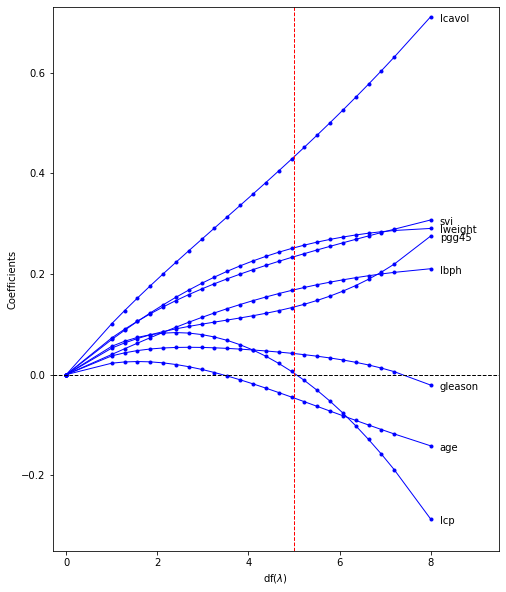

In [167]:
plt.figure(figsize=(8, 10))
for column in coefficients.keys():
    plt.plot(df_lambda, coefficients[column], 'b-o', linewidth=1.0, markersize=3)
    plt.annotate(column, xy=(8.2, coefficients[column][-1] - 0.01))

plt.xlim([-0.3, 9.5])
plt.ylim([-0.35, 0.73])
plt.plot(np.linspace(-0.3, 9.5, len(df_lambda)), np.zeros_like(df_lambda), 'k--', linewidth=1.0)
plt.plot(5 * np.ones(len(np.linspace(-0.35, 0.73))), np.linspace(-0.35, 0.73), 'r--', linewidth=1.0)
plt.xlabel('df($\lambda$)')
plt.ylabel('Coefficients')
plt.show()